<center><font size= "200"><font color=”Blue”> Named Entity Recognition </font></center>

##Author: Partheesh Marwah


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv( "/content/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False, usecols=['sentence_idx', 'word', 'tag'])
df  = df[df['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
print(df.shape)
df.head()

<ipython-input-58-346c1bc1f993>:1: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



<ipython-input-58-346c1bc1f993>:1: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



(1050794, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


In [ ]:
# Grouping by 'sentence_idx' and apply a lambda function to create a list of (word, tag) tuples for each group
sentences = df.groupby('sentence_idx').apply(lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]).tolist()

# Now 'sentences' is a list of sentences, and each sentence is a list of (word, tag) tuples
print(sentences[6])  # Print the first sentence as an example

[('The', 'O'), ('London', 'B-geo'), ('march', 'O'), ('came', 'O'), ('ahead', 'O'), ('of', 'O'), ('anti-war', 'O'), ('protests', 'O'), ('today', 'O'), ('in', 'O'), ('other', 'O'), ('cities', 'O'), (',', 'O'), ('including', 'O'), ('Rome', 'B-geo'), (',', 'O'), ('Paris', 'B-geo'), (',', 'O'), ('and', 'O'), ('Madrid', 'B-geo'), ('.', 'O')]


<center><font size= "20"><font color=Red> Data Visualization </font></center>

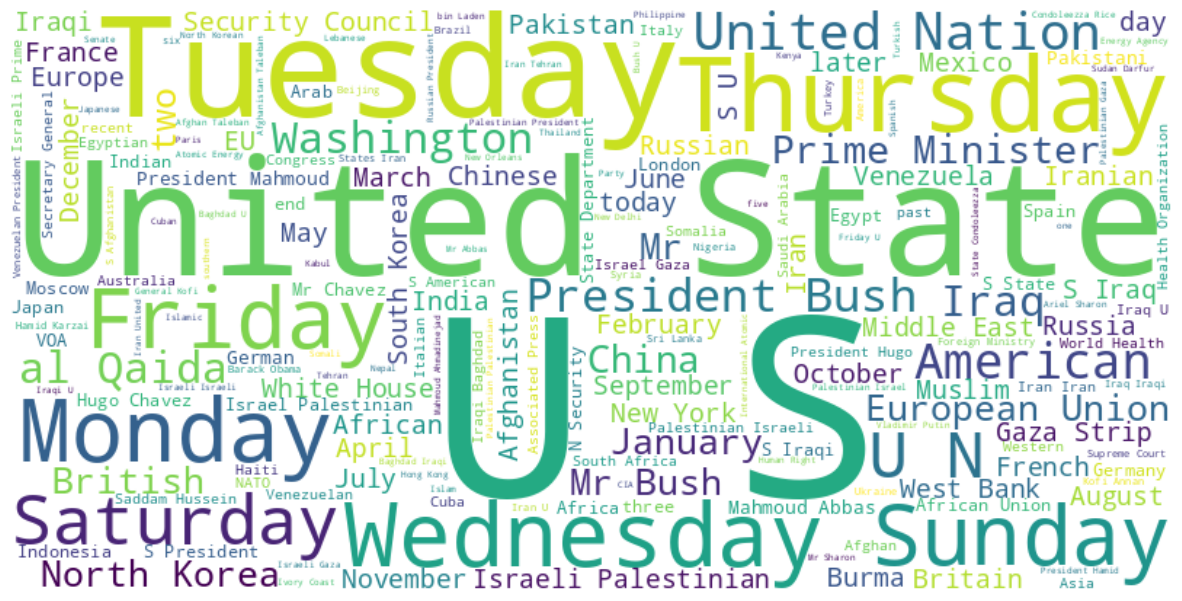

In [ ]:
from wordcloud import WordCloud
# Generating a word cloud image, converting all non-null words to strings
entity_df = df[df['tag'] != 'O']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(entity_df['word'].dropna().astype(str))
)

# Displaying the word cloud using matplotlib
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

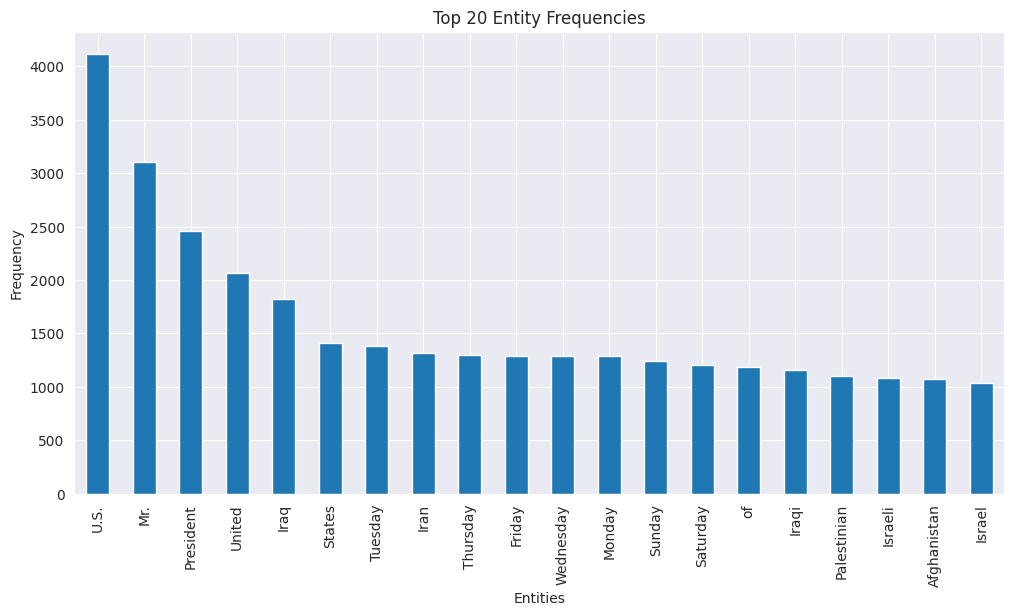

In [ ]:
# Getting the frequency of each word/entity
word_freq = entity_df['word'].value_counts()

# Plotting the frequencies
plt.figure(figsize=(12, 6))
word_freq.head(20).plot(kind='bar')  # Only show the top 20 entities
plt.title('Top 20 Entity Frequencies')
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import plotly.express as px
# Plotting the tagging frequencies
fig = px.histogram(df[df['tag'].str.contains("O", na=False) == False], x="tag", color="tag")
fig.show()

Number of Sentences: 36684
Maximum sequence length: 140
Number of unique words: 30173


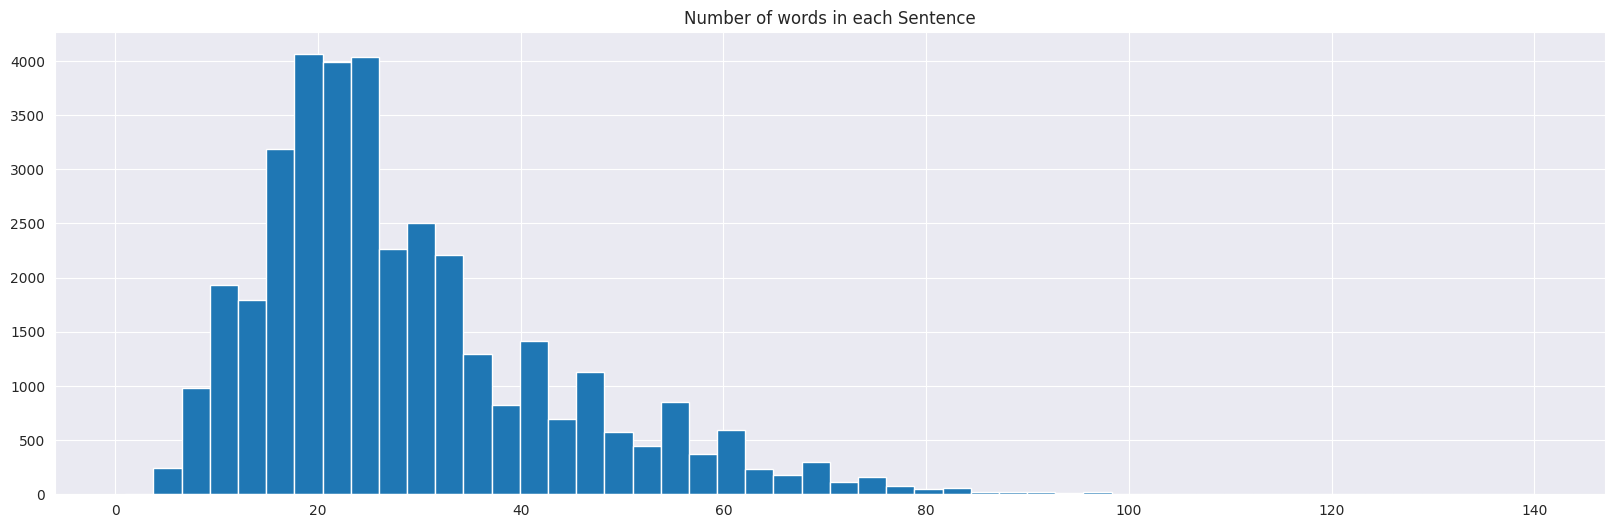

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentences])
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

words = list(set(df["word"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

<center><font size= "200"><font color=”Blue”> Model Fit & Training </font></center>

In [ ]:
tags = list(set(df["tag"].values))
n_tags = len(tags)
word2idx = {w: i for i, w in enumerate(words)} ## Creating a dictionary to convert words to unique integers
tag2idx = {t: i for i, t in enumerate(tags)} ## Create a dictionary to convert tags to unique integers

The word2idx and tag2idx dictionaries are foundational for transforming the raw text data into a format that can be processed by a neural network.

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical

In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]  ## Convert each sentence to a list of word indices
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1) ##Pad the sequences so that all have the same length for model input

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (36684, 140) y shape (36684, 140, 17)


1: It converts words into vectors that capture semantic meaning.
<br>2:It uses LSTM layers to analyze sequences, considering the context from both directions in the sentence.
<br>3: It makes predictions for each word, classifying them into categories like person, organization, location, etc., based on learned patterns from the training data.</br>

In [ ]:
class config():
    # Vocabulary size
    VOCAB = n_words
    # Maximum sequence length
    MAX_LEN = maxlen
    # Number of entity output tags
    N_OUTPUT = n_tags

    # Embedding layer parameters
    EMBEDDING_VECTOR_LENGTH = 50
    EMBEDDING_DROPOUT = 0.5       # Dropout rate for embedding layer

    # LSTM layer parameters
    N_LSTM_CELLS = 128
    LSTM_DROPOUT = 0.5            # Dropout rate for LSTM layers
    RECURRENT_DROPOUT = 0.1       # Recurrent dropout rate for LSTM layers
    LSTM_STACKED_LAYERS = 2       # Number of stacked LSTM layers

    # Dense layer parameters
    DENSE_UNITS = 128
    DENSE_DROPOUT = 0.5           # Dropout rate for dense layer

    # Output layer parameters
    OUTPUT_ACTIVATION = 'softmax' # Activation function for the output layer

    # Model compilation parameters
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    LEARNING_RATE = 0.001         # Initial learning rate
    DECAY = 1e-6                  # Learning rate decay over each update

    # Training parameters
    BATCH_SIZE = 64               # Batch size for training
    MAX_EPOCHS = 10               # Number of epochs to train for
    VALIDATION_SPLIT = 0.1        # Fraction of data to use for validation

    # Callback parameters
    EARLY_STOPPING_PATIENCE = 5   # Early stopping patience
    REDUCE_LR_PATIENCE = 2        # Patience for reducing learning rate
    REDUCE_LR_FACTOR = 0.5        # Factor by which the learning rate will be reduced. new_lr = lr * factor
    CHECKPOINT_PATH = "model.h5"  # Path to save the model file

In [ ]:
VOCAB = n_words
MAX_LEN = maxlen
N_OUTPUT = n_tags

model_1 = Sequential()
# Keras Embedding layer has defaults: embeddings_initializer="uniform" and others
model_1.add(Embedding(input_dim=VOCAB, output_dim=50, input_length=MAX_LEN)) # It's essentially a lookup table that learns to map each word index to a dense vector representing that word.
# Keras LSTM layer has defaults: dropout=0, recurrent_dropout=0, etc.
model_1.add(Bidirectional(LSTM(64, return_sequences=True))) #The Bidirectional wrapper allows the LSTM to process the sequence in both forward and backward directions, capturing context from both the past and the future.
# TimeDistributed Dense layer will have the softmax activation by default for multi-class classification
model_1.add(TimeDistributed(Dense(N_OUTPUT, activation='softmax'))) #This layer applies a Dense (fully connected) layer to each time step of the sequence.
# Keras compile has defaults: loss will be categorical_crossentropy and optimizer will be RMSprop for this example
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_1.summary()

# Callbacks with some default values (patience and verbose are specified, but others are defaults)
es = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
filepath = "model_1.h5"
ckpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
rlp = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 140, 50)           1508650   
                                                                 
 bidirectional_5 (Bidirecti  (None, 140, 128)          58880     
 onal)                                                           
                                                                 
 time_distributed_5 (TimeDi  (None, 140, 17)           2193      
 stributed)                                                      
                                                                 
Total params: 1569723 (5.99 MB)
Trainable params: 1569723 (5.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_1 = model_1.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=config.MAX_EPOCHS
)

Epoch 1/10
1032/1032 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9746
Epoch 1: val_loss improved from inf to 0.03395, saving model to model_1.h5
1032/1032 [==============================] - 184s 174ms/step - loss: 0.1277 - accuracy: 0.9746 - val_loss: 0.0339 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1032/1032 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9916
Epoch 2: val_loss improved from 0.03395 to 0.02129, saving model to model_1.h5
1032/1032 [==============================] - 199s 193ms/step - loss: 0.0295 - accuracy: 0.9916 - val_loss: 0.0213 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 3/10
1032/1032 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9941
Epoch 3: val_loss improved from 0.02129 to 0.01904, saving model to model_1.h5
1032/1032 [==============================] - 173s 167ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0190 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 4/10
1032/1032 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9952
Epoch 4: val_loss improved from 0.01904 to 0.01794, saving model to model_1.h5
1032/1032 [==============================] - 165s 160ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0179 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 5/10
1032/1032 [========

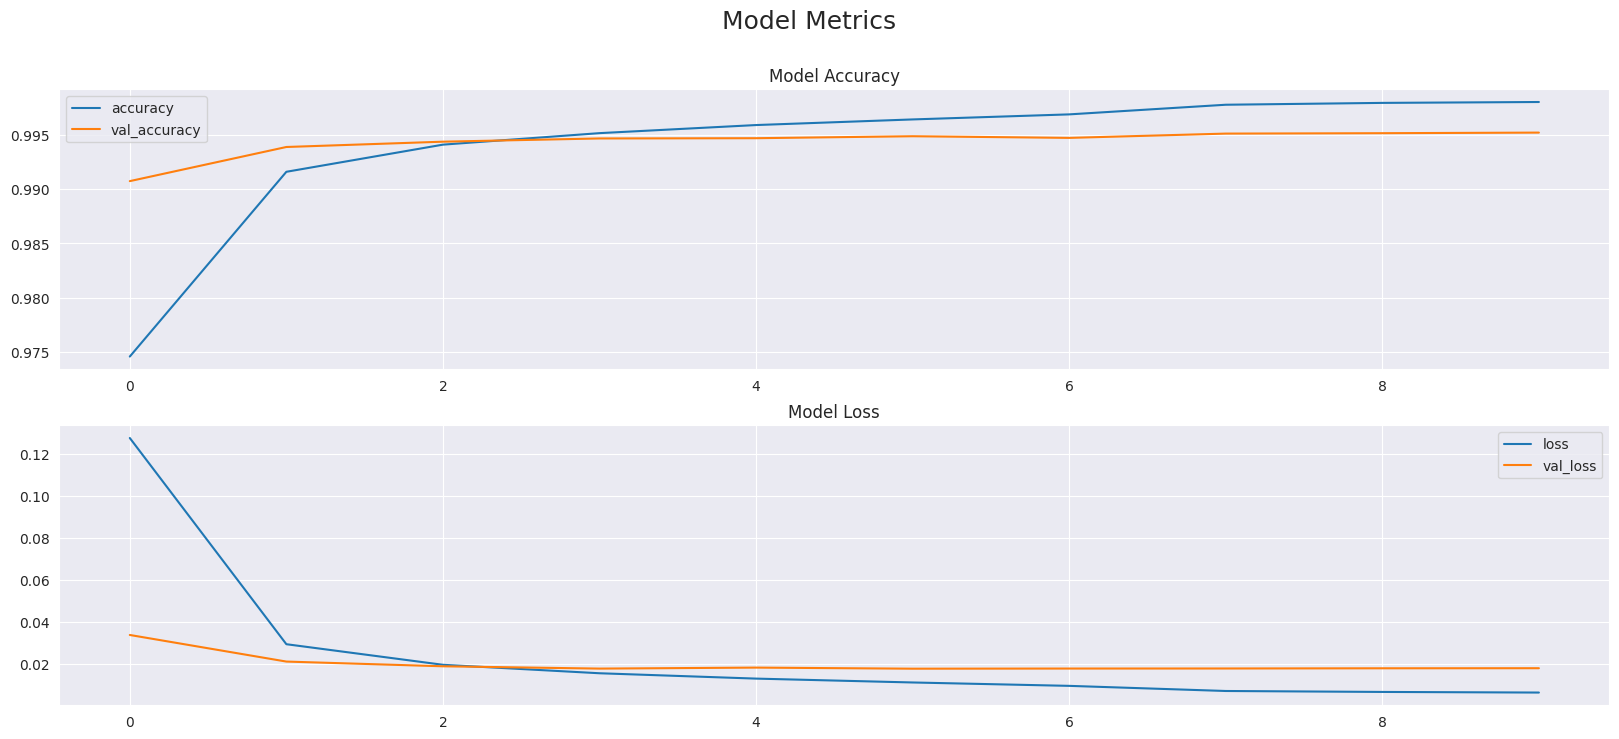

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history_1.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [ ]:
i = np.random.randint(0, X.shape[0])
p = model_1.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD':
        break

1/1 [==============================] - 1s 833ms/step
Word           True 	Pred
------------------------------
In             O	O
an             O	O
interview      O	O
published      O	O
Friday         B-tim	B-tim
by             O	O
a              O	O
leading        O	O
U.S.           B-geo	B-geo
newspaper      O	O
,              O	O
Ms.            B-per	B-per
Rice           I-per	I-per
said           O	O
Israeli        B-gpe	B-gpe
plans          O	O
to             O	O
build          O	O
additional     O	O
homes          O	O
in             O	O
the            O	O
Maaleh         B-geo	B-geo
Adumin         I-geo	I-geo
settlement     O	O
could          O	O
threaten       O	O
peace          O	O
with           O	O
the            O	O
Palestinians   B-gpe	B-gpe
and            O	O
is             O	O
at             O	O
odds           O	O
with           O	O
American       B-gpe	B-gpe
policy         O	O
.              O	O
In             O	O
an             O	O
interview      O	O
published      O	O
F

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 140, 50)           1508650   
                                                                 
 bidirectional_4 (Bidirecti  (None, 140, 128)          58880     
 onal)                                                           
                                                                 
 time_distributed_4 (TimeDi  (None, 140, 17)           2193      
 stributed)                                                      
                                                                 
Total params: 1569723 (5.99 MB)
Trainable params: 1569723 (5.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


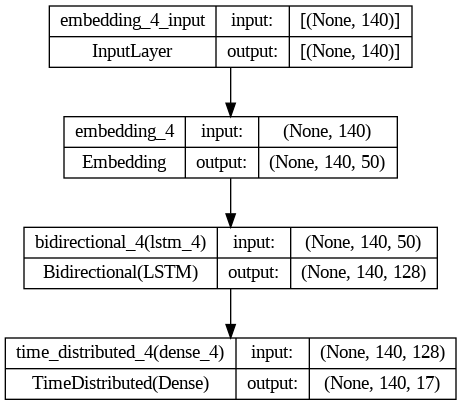

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model_2.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model_2 = Sequential()
model_2.add(
    Embedding(input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN)
)
model_2.add(
    Bidirectional(LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT))
)
model_2.add(
    TimeDistributed( Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION))
)
model_2.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model_2.summary()
plot_model(model_2, show_shapes=True)

In [ ]:
history = model_2.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=5
)

Epoch 1/5
1032/1032 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9752
Epoch 1: loss improved from inf to 0.12910, saving model to model_2.h5
1032/1032 [==============================] - 360s 344ms/step - loss: 0.1291 - accuracy: 0.9752 - val_loss: 0.0364 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1032/1032 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9912
Epoch 2: loss improved from 0.12910 to 0.03175, saving model to model_2.h5
1032/1032 [==============================] - 353s 343ms/step - loss: 0.0318 - accuracy: 0.9912 - val_loss: 0.0223 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 3/5
1032/1032 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9939
Epoch 3: loss improved from 0.03175 to 0.02090, saving model to model_2.h5
1032/1032 [==============================] - 350s 339ms/step - loss: 0.0209 - accuracy: 0.9939 - val_loss: 0.0193 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 4/5
1032/1032 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9949
Epoch 4: loss improved from 0.02090 to 0.01675, saving model to model_2.h5
1032/1032 [==============================] - 358s 347ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0185 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 5/5
1032/1032 [=======================

In [ ]:
i = np.random.randint(0, X.shape[0])
p = model_2.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD':
        break

1/1 [==============================] - 1s 1s/step
Word           True 	Pred
------------------------------
For            O	O
Widhoelzl      B-per	B-per
,              O	O
Saturday       B-tim	B-tim
's             O	O
result         O	O
was            O	O
his            O	O
second         O	O
world          O	O
silver         O	O
medal          O	O
-              O	O
he             O	O
also           O	O
finished       O	O
second         O	O
in             O	O
2000           B-tim	B-tim
.              O	O
ENDPAD         O	O
